# Daily Pizza Sales Prediction


#### Project Workflow
1. Understand the Dataset
- Review all columns and their meanings (you’ve already done this — great start!)
- Identify which variables are:
- Independent (features): weather, promotions, school status, holidays, etc.
- Dependent (target): daily_sales
2. Clean and Prepare the Data
- Check for missing values or anomalies (e.g., nulls in temperature or sales)
- Convert date column to datetime format
- Create new features if needed:
- Week number
- Is exam week
- Ramadan or Lent flag (already modeled, but you can double-check)
3. Explore the Data (EDA)
Use visualizations to uncover patterns:
- 📈 Line plots of sales over time
- 📊 Bar charts comparing average sales by:
- Day of week
- Month
- Holiday vs non-holiday
- School in session vs strike
- 📉 Boxplots to see sales distribution by weather or promotion
- 📌 Correlation heatmap to see which features influence sales most
4. Model Sales Drivers
- Use regression models (e.g., Linear Regression, Random Forest, XGBoost) to predict daily_sales
- Evaluate feature importance: which variables drive sales the most?
- Try time series models (e.g., ARIMA, Prophet) if you're forecasting future sales
5. Segment Your Insights
- Compare sales during:
- Strike vs normal periods
- Ramadan vs non-Ramadan
- Exam weeks vs regular weeks
- Identify high-performing days (e.g., Fridays with promotions)
6. Make Recommendations
Based on your findings, suggest:
- Best times to run promotions
- How to prepare for low-traffic periods (e.g., strikes, Lent)
- Staffing or inventory adjustments based on seasonality
7. Present Your Work
- Create a dashboard (Excel, Power BI, or Tableau)
- Summarize key insights in a slide deck or report
- Include visuals, trends, and actionable takeaways


# Data Cleaning

In [1]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#Importing Dataset
df = pd.read_csv('pizza_sales_2021_2025.csv')

In [3]:
df.head()

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,university_calendar_status,is_school_in_session,weather,temperature_C,promotion,foot_traffic_index,student_density_index,daily_sales_NGN,transactions_count,avg_order_value_NGN,ramadan,lent
0,2021-01-01,Friday,1,False,True,New Year's Day,In Session,True,Sunny,28.3,False,68,78,98547,66,1493.14,False,False
1,2021-01-02,Saturday,1,True,False,NaN,In Session,True,Sunny,30.8,False,63,77,91897,62,1482.21,False,False
2,2021-01-03,Sunday,1,True,False,NaN,In Session,True,Sunny,29.4,False,81,67,109870,70,1569.57,False,False
3,2021-01-04,Monday,1,False,False,NaN,In Session,True,Sunny,27.9,False,64,63,86930,57,1525.09,False,False
4,2021-01-05,Tuesday,1,False,False,NaN,In Session,True,Cloudy,28.5,False,69,73,84555,53,1595.38,False,False


In [4]:
df.columns

Index(['date', 'day_of_week', 'month', 'is_weekend', 'is_holiday',
       'public_holiday_name', 'university_calendar_status',
       'is_school_in_session', 'weather', 'temperature_C', 'promotion',
       'foot_traffic_index', 'student_density_index', 'daily_sales_NGN',
       'transactions_count', 'avg_order_value_NGN', 'ramadan', 'lent'],
      dtype='object')

In [5]:
df.drop(['ramadan', 'lent'], axis=1, inplace=True)

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        1826 non-null   object 
 1   day_of_week                 1826 non-null   object 
 2   month                       1826 non-null   int64  
 3   is_weekend                  1826 non-null   bool   
 4   is_holiday                  1826 non-null   bool   
 5   public_holiday_name         50 non-null     object 
 6   university_calendar_status  1826 non-null   object 
 7   is_school_in_session        1826 non-null   bool   
 8   weather                     1826 non-null   object 
 9   temperature_C               1826 non-null   float64
 10  promotion                   1826 non-null   bool   
 11  foot_traffic_index          1826 non-null   int64  
 12  student_density_index       1826 non-null   int64  
 13  daily_sales_NGN             1826 

In [7]:
df.describe()

,month,temperature_C,foot_traffic_index,student_density_index,daily_sales_NGN,transactions_count,avg_order_value_NGN
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,6.523549,29.338664,54.714677,54.468237,80662.380066,52.444140,1554.985860
std,3.449478,2.650096,16.615595,26.400837,30855.251055,20.966625,152.331414
min,1.000000,21.600000,5.000000,0.000000,22804.000000,14.000000,972.170000
25%,4.000000,27.500000,43.000000,29.000000,52746.000000,34.000000,1451.462500
50%,7.000000,29.500000,56.000000,64.000000,85400.500000,54.000000,1557.300000
75%,10.000000,31.200000,67.000000,76.000000,102584.250000,67.000000,1655.382500
max,12.000000,37.400000,100.000000,100.000000,175656.000000,117.000000,2054.270000


In [8]:
print(df.isnull().sum())

date                             0
day_of_week                      0
month                            0
is_weekend                       0
is_holiday                       0
public_holiday_name           1776
university_calendar_status       0
is_school_in_session             0
weather                          0
temperature_C                    0
promotion                        0
foot_traffic_index               0
student_density_index            0
daily_sales_NGN                  0
transactions_count               0
avg_order_value_NGN              0
dtype: int64


`Note: `In the `public_holiday_name` column, missing values likely mean “not a public holiday” — which is perfectly valid. So these aren’t errors or gaps in data collection, they’re just non-holiday days.
- Since `is_holiday` as a Boolean column — so you can use that to filter or group.
- Also, When `is_holiday` = False, it’s expected that public_holiday_name = NaN.





In [9]:
# Check for Duplicates
print(df.duplicated().sum())

0


In [10]:
#Check and FIx Data Types
print(df.dtypes)

date                           object
day_of_week                    object
month                           int64
is_weekend                       bool
is_holiday                       bool
public_holiday_name            object
university_calendar_status     object
is_school_in_session             bool
weather                        object
temperature_C                 float64
promotion                        bool
foot_traffic_index              int64
student_density_index           int64
daily_sales_NGN                 int64
transactions_count              int64
avg_order_value_NGN           float64
dtype: object


In [11]:
# Convert Date column to datetime dtype
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [12]:
#Convert Category columns to category dtype
cat_cols = ['day_of_week', 'month', 'public_holiday_name', 'university_calendar_status', 'weather']
for col in cat_cols:
    df[col] = df[col].astype('category')
    

In [13]:
#Convert Boolean columns to bool dtype
bool_cols = ['is_weekend', 'is_holiday', 'is_school_in_session', 'promotion']
for col in bool_cols:
    df[col] = df[col].astype('bool')

In [14]:
#Convert Numeric Columns to floats type
num_cols = ['temperature_C', 'foot_traffic_index', 'student_density_index', 'daily_sales_NGN', 'transactions_count', 'avg_order_value_NGN']
for col in num_cols:  
    df[col] = df[col].astype('float64')


In [15]:
print(df.dtypes)

date                          datetime64[ns]
day_of_week                         category
month                               category
is_weekend                              bool
is_holiday                              bool
public_holiday_name                 category
university_calendar_status          category
is_school_in_session                    bool
weather                             category
temperature_C                        float64
promotion                               bool
foot_traffic_index                   float64
student_density_index                float64
daily_sales_NGN                      float64
transactions_count                   float64
avg_order_value_NGN                  float64
dtype: object


In [16]:
# Checking Time Continuity to ensure no missing dates

# Create a complete date range
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Compare with actual dates
missing_dates = full_range.difference(df['date'])

print(f"Missing dates: {missing_dates}")


Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## Exploratory Data Analysis

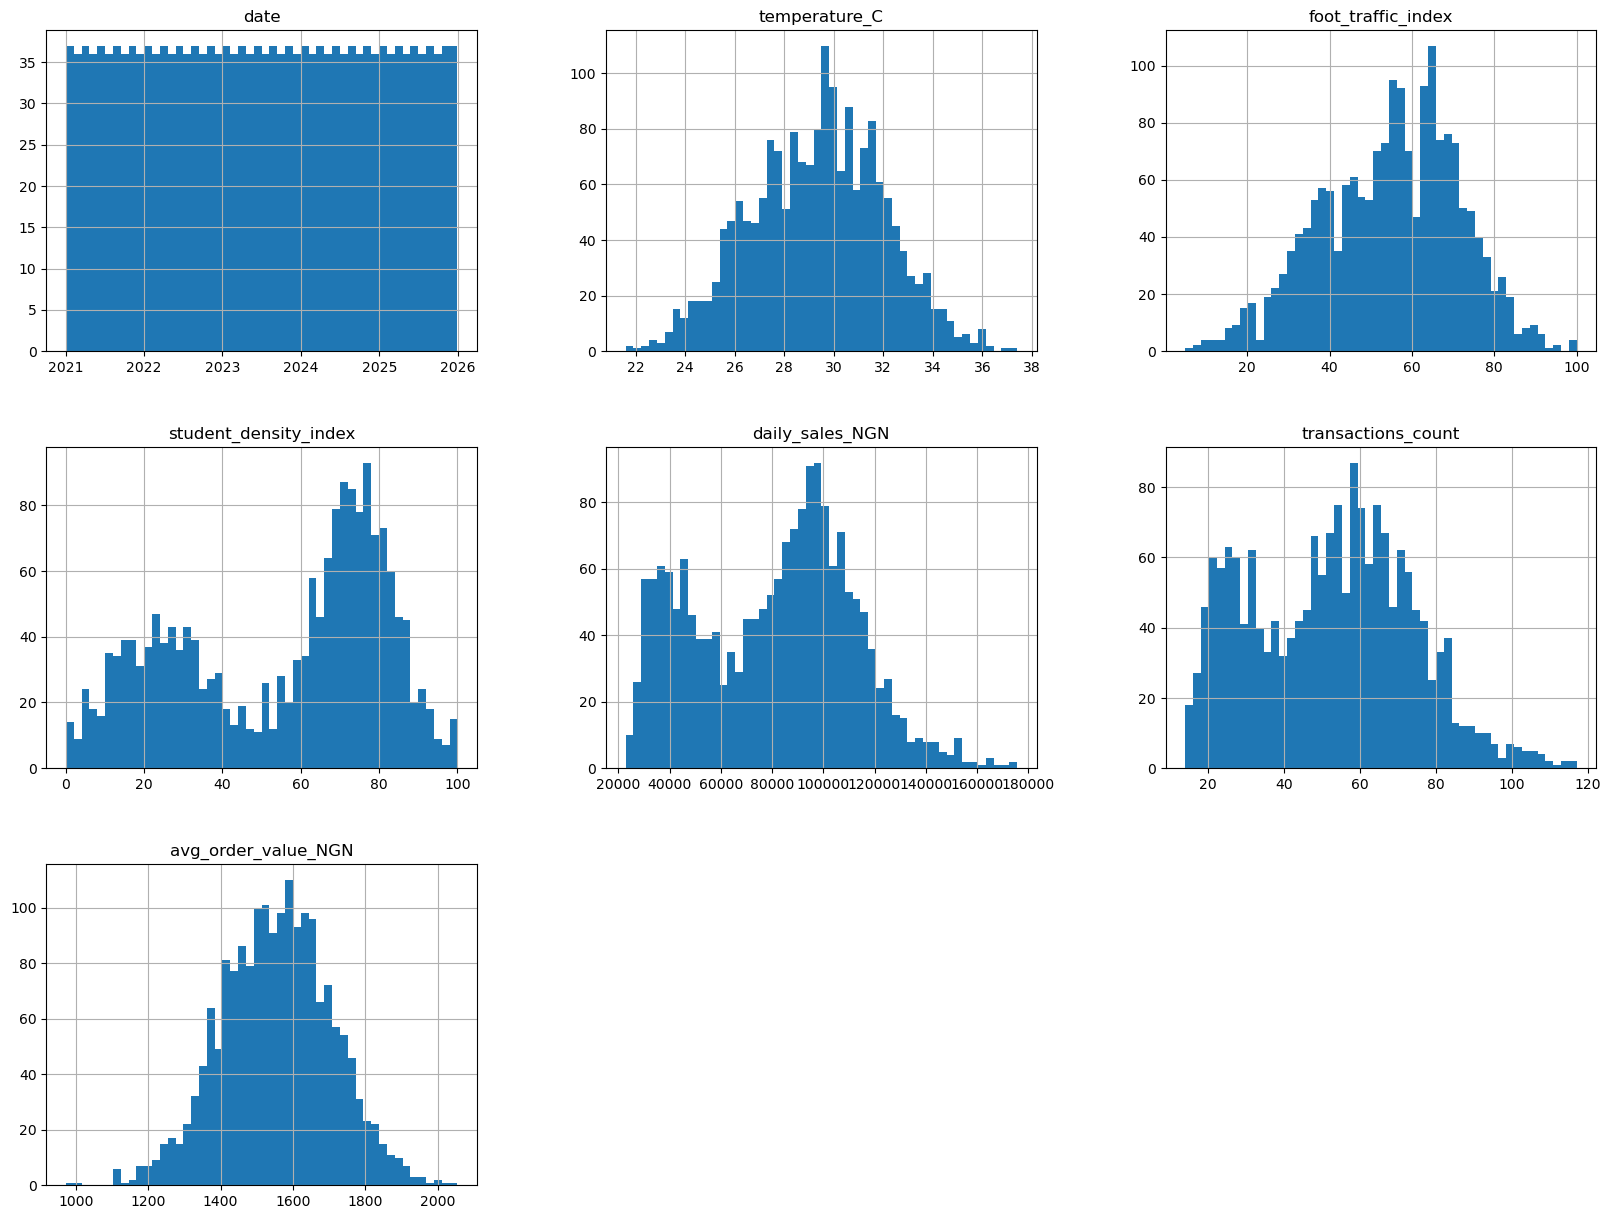

In [17]:
# plot a histogram for each numerical attribute
df.hist(bins=50, figsize=(20,15))
plt.show()


       daily_sales_NGN  temperature_C  student_density_index  \
count      1826.000000    1826.000000            1826.000000   
mean      80662.380066      29.338664              54.468237   
std       30855.251055       2.650096              26.400837   
min       22804.000000      21.600000               0.000000   
25%       52746.000000      27.500000              29.000000   
50%       85400.500000      29.500000              64.000000   
75%      102584.250000      31.200000              76.000000   
max      175656.000000      37.400000             100.000000   

       foot_traffic_index  transactions_count  avg_order_value_NGN  
count         1826.000000         1826.000000          1826.000000  
mean            54.714677           52.444140          1554.985860  
std             16.615595           20.966625           152.331414  
min              5.000000           14.000000           972.170000  
25%             43.000000           34.000000          1451.462500  
50%      

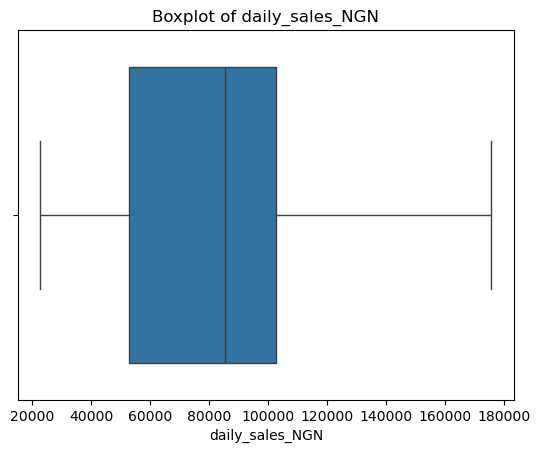

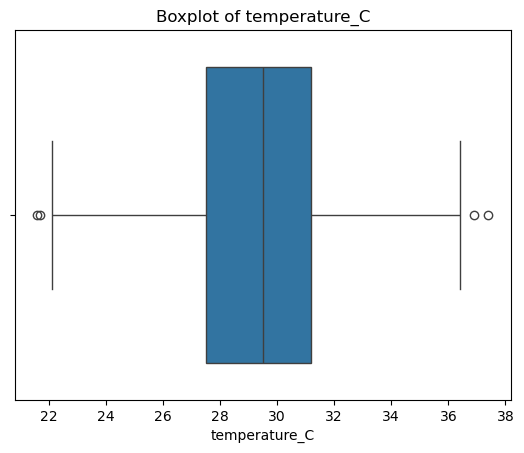

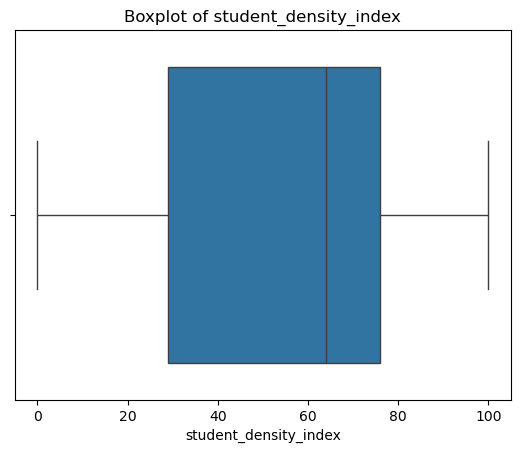

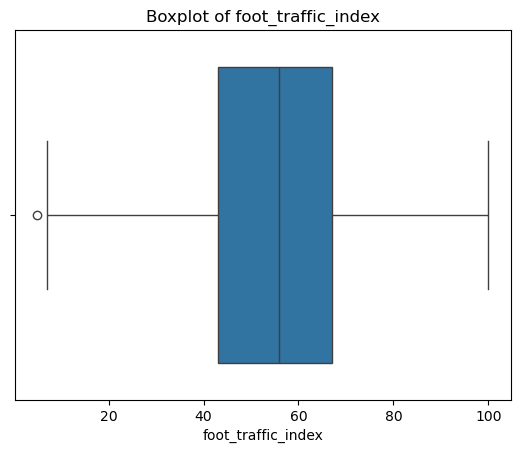

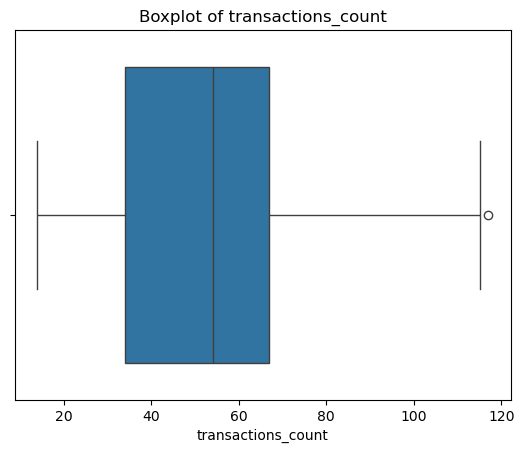

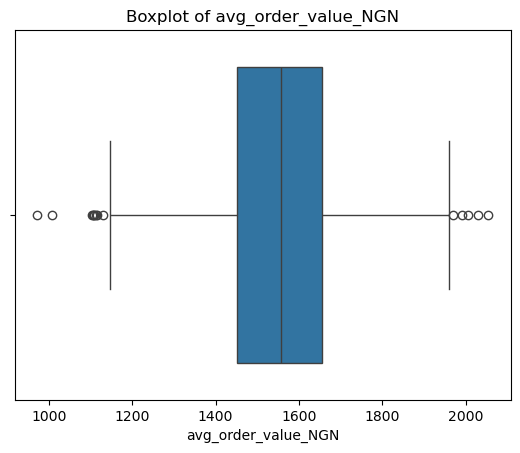

In [18]:
# Summary stats
print(
    df[['daily_sales_NGN', 'temperature_C', 'student_density_index', 'foot_traffic_index', 'transactions_count', 'avg_order_value_NGN']].describe()
)


# Visualizing boxplots for numerical columns
for col in ['daily_sales_NGN', 'temperature_C', 'student_density_index', 'foot_traffic_index', 'transactions_count', 'avg_order_value_NGN']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### Looking for Correlations

In [19]:
corr_matrix = df[num_cols].corr()

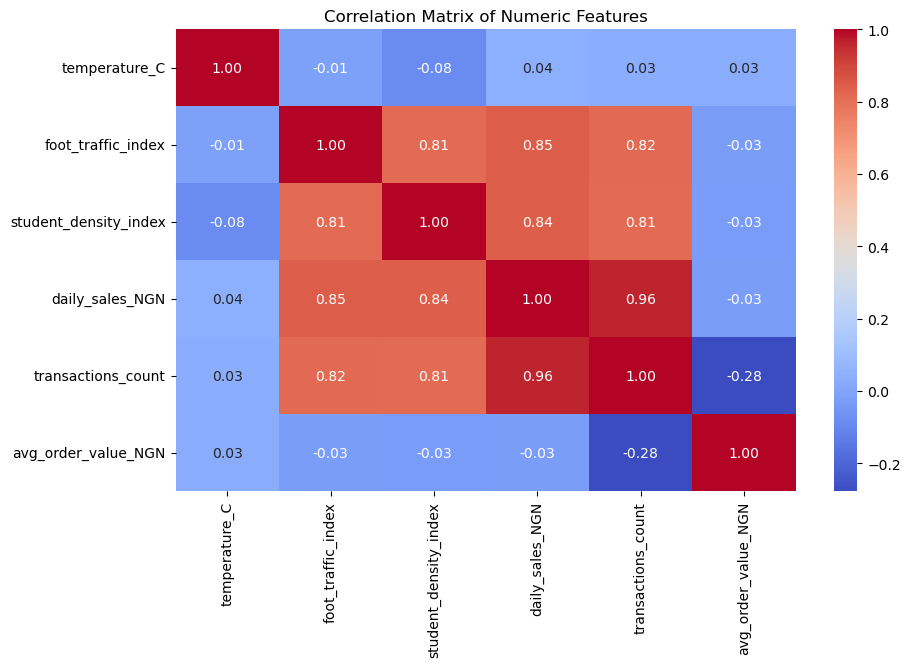

In [20]:
# Visualizing the correlation matrix using a heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

Understand the `correlation martix` before continuing with Data Preprocessing

## Data Preprocessing

- Handle Missing Values
- Define Variables
- Feature Engineering & Featur Scaling where necessary
- Encoding Categorical data


`Note:` For Feature engineering on this project;

 Addressing Special Non-Public HolidaysYou should create a new binary feature specifically to capture the effect of fixed, non-official holidays that dramatically influence consumer spending and dining habits.
 1. Create a New Feature: Festive_Day_FlagInstead of trying to fit Valentine's Day into the Is_Holiday column (which should be reserved only for nationally recognized public holidays), you should create a separate binary flag:
 
- New Column Name:  Festive_Day_FlagBinary
- DataType: (0 or 1)
- Description : 1 if the date is a major, fixed festive day known to influence dining, 0 otherwise
- Dates to Flag (Examples): February 14th (Valentine's), Mother's Day, Father's Day, New Year's Eve (Dec 31st).


`Note:` for Encoding Categorical Data;
1. One-Hot Encoding (Dummy Variables)
Best for tree-based models (Random Forest, XGBoost) and linear models.
`df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)`

- drop_first=True avoids multicollinearity by removing one category per feature.
- This turns each category into a binary column (0 or 1).


In [21]:
print(df.columns)


Index(['date', 'day_of_week', 'month', 'is_weekend', 'is_holiday',
       'public_holiday_name', 'university_calendar_status',
       'is_school_in_session', 'weather', 'temperature_C', 'promotion',
       'foot_traffic_index', 'student_density_index', 'daily_sales_NGN',
       'transactions_count', 'avg_order_value_NGN'],
      dtype='object')


In [22]:
#Feature Engineering #Lag Features
# Sales lags
df['sales_lag_1'] = df['daily_sales_NGN'].shift(1)
df['sales_lag_7'] = df['daily_sales_NGN'].shift(7)
df['sales_lag_30'] = df['daily_sales_NGN'].shift(30)

# Foot traffic lags
df['traffic_lag_1'] = df['foot_traffic_index'].shift(1)
df['traffic_lag_7'] = df['foot_traffic_index'].shift(7)

# Transactions lags
df['transactions_lag_1'] = df['transactions_count'].shift(1)
df['transactions_lag_7'] = df['transactions_count'].shift(7)


In [23]:
#Rolling averages; helps the model understand recent trends and smooth out daily noise.

# Rolling averages for sales
df['sales_7d_avg'] = df['daily_sales_NGN'].rolling(window=7).mean()
df['sales_30d_avg'] = df['daily_sales_NGN'].rolling(window=30).mean()

# Rolling averages for foot traffic and transactions
df['traffic_7d_avg'] = df['foot_traffic_index'].rolling(window=7).mean()
df['transactions_7d_avg'] = df['transactions_count'].rolling(window=7).mean()
df.head(15)

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,university_calendar_status,is_school_in_session,weather,temperature_C,...,sales_lag_7,sales_lag_30,traffic_lag_1,traffic_lag_7,transactions_lag_1,transactions_lag_7,sales_7d_avg,sales_30d_avg,traffic_7d_avg,transactions_7d_avg
0,2021-01-01,Friday,1,False,True,New Year's Day,In Session,True,Sunny,28.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,Saturday,1,True,False,NaN,In Session,True,Sunny,30.8,...,NaN,NaN,68.0,NaN,66.0,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,Sunday,1,True,False,NaN,In Session,True,Sunny,29.4,...,NaN,NaN,63.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,Monday,1,False,False,NaN,In Session,True,Sunny,27.9,...,NaN,NaN,81.0,NaN,70.0,NaN,NaN,NaN,NaN,NaN
4,2021-01-05,Tuesday,1,False,False,NaN,In Session,True,Cloudy,28.5,...,NaN,NaN,64.0,NaN,57.0,NaN,NaN,NaN,NaN,NaN
5,2021-01-06,Wednesday,1,False,False,NaN,In Session,True,Sunny,27.1,...,NaN,NaN,69.0,NaN,53.0,NaN,NaN,NaN,NaN,NaN
6,2021-01-07,Thursday,1,False,False,NaN,In Session,True,Sunny,31.2,...,NaN,NaN,72.0,NaN,66.0,NaN,93206.571429,NaN,69.000000,60.571429
7,2021-01-08,Friday,1,False,False,NaN,In Session,True,Sunny,29.4,...,98547.0,NaN,66.0,68.0,50.0,66.0,93756.571429,NaN,69.000000,59.714286
8,2021-01-09,Saturday,1,True,False,NaN,In Session,True,Cloudy,29.7,...,91897.0,NaN,68.0,63.0,60.0,62.0,96673.000000,NaN,70.142857,61.714286
9,2021-01-10,Sunday,1,True,False,NaN,In Session,True,Sunny,29.7,...,109870.0,NaN,71.0,81.0,76.0,70.0,98223.571429,NaN,71.142857,61.857143


Find answeres to this later;  If I drop the rows of the columns with NaN values, how will the model learn from the detials of their other colums with useful detials

In [24]:
# Adding non official public holidays or festive days that migh affect daily sales

festive_days = [
    '2021-02-14', '2021-03-14', '2021-06-20', '2021-12-24', '2021-12-31',
    '2022-02-14', '2022-03-27', '2022-06-19', '2022-12-24', '2022-12-31',
    '2023-02-14', '2023-03-19', '2023-06-18', '2023-12-24', '2023-12-31',
    '2024-02-14', '2024-03-10', '2024-06-16', '2024-12-24', '2024-12-31',
    '2025-02-14', '2025-03-30', '2025-06-15', '2025-12-24', '2025-12-31'
]

In [25]:
# Adding the names of the non official public holidays

festive_names = {
    '2021-02-14': "Valentine's Day",
    '2021-03-14': "Mother's Day",
    '2021-06-20': "Father's Day",
    '2021-12-24': "Christmas Eve",
    '2021-12-31': "New Year's Eve",
    '2022-02-14': "Valentine's Day",
    '2022-03-27': "Mother's Day",
    '2022-06-19': "Father's Day",
    '2022-12-24': "Christmas Eve",
    '2022-12-31': "New Year's Eve",
    '2023-02-14': "Valentine's Day",
    '2023-03-19': "Mother's Day",
    '2023-06-18': "Father's Day",
    '2023-12-24': "Christmas Eve",
    '2023-12-31': "New Year's Eve",
    '2024-02-14': "Valentine's Day",
    '2024-03-10': "Mother's Day",
    '2024-06-16': "Father's Day",
    '2024-12-24': "Christmas Eve",
    '2024-12-31': "New Year's Eve",
    '2025-02-14': "Valentine's Day",
    '2025-03-30': "Mother's Day",
    '2025-06-15': "Father's Day",
    '2025-12-24': "Christmas Eve",
    '2025-12-31': "New Year's Eve"
}

In [26]:
#Convert Date Column to String Format for mapping
df['date_str'] = df['date'].dt.strftime('%Y-%m-%d') 


In [27]:
# Update the colums to include festive days and their names
df.loc[df['date_str'].isin(festive_days), 'is_holiday'] = True


# Append festive names to public holiday name
df['public_holiday_name'] = df.apply(
    lambda row: festive_names[row['date_str']] if row['date_str'] in festive_names
    else row['public_holiday_name'], axis=1
)

In [28]:
df.drop(columns=['date_str'], inplace=True) #drop the date column in str format

In [29]:
df

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,university_calendar_status,is_school_in_session,weather,temperature_C,...,sales_lag_7,sales_lag_30,traffic_lag_1,traffic_lag_7,transactions_lag_1,transactions_lag_7,sales_7d_avg,sales_30d_avg,traffic_7d_avg,transactions_7d_avg
0,2021-01-01,Friday,1,False,True,New Year's Day,In Session,True,Sunny,28.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,Saturday,1,True,False,NaN,In Session,True,Sunny,30.8,...,NaN,NaN,68.0,NaN,66.0,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,Sunday,1,True,False,NaN,In Session,True,Sunny,29.4,...,NaN,NaN,63.0,NaN,62.0,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,Monday,1,False,False,NaN,In Session,True,Sunny,27.9,...,NaN,NaN,81.0,NaN,70.0,NaN,NaN,NaN,NaN,NaN
4,2021-01-05,Tuesday,1,False,False,NaN,In Session,True,Cloudy,28.5,...,NaN,NaN,64.0,NaN,57.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2025-12-27,Saturday,12,True,False,NaN,Semester Break,False,Sunny,28.4,...,71449.0,57459.0,38.0,50.0,31.0,46.0,77243.428571,73703.033333,43.000000,50.285714
1822,2025-12-28,Sunday,12,True,False,NaN,Semester Break,False,Cloudy,30.5,...,83661.0,50933.0,57.0,46.0,61.0,54.0,77265.000000,74799.000000,45.000000,49.571429
1823,2025-12-29,Monday,12,False,False,NaN,Semester Break,False,Sunny,31.7,...,71243.0,59400.0,60.0,47.0,49.0,49.0,76199.285714,74945.100000,44.714286,47.571429
1824,2025-12-30,Tuesday,12,False,False,NaN,Semester Break,False,Rainy,27.7,...,71121.0,63889.0,45.0,38.0,35.0,49.0,74675.571429,74830.633333,43.428571,45.714286


- Cyclical Time Encoding — turn day_of_week and month into sine/cosine features
- Train-Test Split — prepare your data for modeling
- Feature Selection — identify the most predictive features
- Modeling — build and evaluate your forecasting model


In [30]:
# Handling Missing Values after Feature Engineering
print(df.isnull().sum())

date                             0
day_of_week                      0
month                            0
is_weekend                       0
is_holiday                       0
public_holiday_name           1753
university_calendar_status       0
is_school_in_session             0
weather                          0
temperature_C                    0
promotion                        0
foot_traffic_index               0
student_density_index            0
daily_sales_NGN                  0
transactions_count               0
avg_order_value_NGN              0
sales_lag_1                      1
sales_lag_7                      7
sales_lag_30                    30
traffic_lag_1                    1
traffic_lag_7                    7
transactions_lag_1               1
transactions_lag_7               7
sales_7d_avg                     6
sales_30d_avg                   29
traffic_7d_avg                   6
transactions_7d_avg              6
dtype: int64


In [31]:
# Handling NaNs in 'public_holiday_name'
df['public_holiday_name'] = df['public_holiday_name'].fillna('None')


In [32]:

df = df.dropna().copy()  # drop rows with any remaining NaNs

In [33]:
print(df.isnull().sum())

date                          0
day_of_week                   0
month                         0
is_weekend                    0
is_holiday                    0
public_holiday_name           0
university_calendar_status    0
is_school_in_session          0
weather                       0
temperature_C                 0
promotion                     0
foot_traffic_index            0
student_density_index         0
daily_sales_NGN               0
transactions_count            0
avg_order_value_NGN           0
sales_lag_1                   0
sales_lag_7                   0
sales_lag_30                  0
traffic_lag_1                 0
traffic_lag_7                 0
transactions_lag_1            0
transactions_lag_7            0
sales_7d_avg                  0
sales_30d_avg                 0
traffic_7d_avg                0
transactions_7d_avg           0
dtype: int64


### Encoding Categorical Data

In [34]:
# cyclical encoding of date features
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['date'].dt.month            # January=1, December=12


In [35]:
# Apply sine and cosine transformations
import numpy as np

# Day of week (7-day cycle)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Month (12-month cycle)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


In [36]:
df.head()

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,university_calendar_status,is_school_in_session,weather,temperature_C,...,transactions_lag_1,transactions_lag_7,sales_7d_avg,sales_30d_avg,traffic_7d_avg,transactions_7d_avg,dow_sin,dow_cos,month_sin,month_cos
30,2021-01-31,6,1,True,False,None,In Session,True,Sunny,31.6,...,67.0,78.0,95004.428571,99346.533333,67.285714,62.571429,-0.781831,0.623490,0.500000,0.866025
31,2021-02-01,0,2,False,False,None,In Session,True,Cloudy,29.6,...,93.0,50.0,99483.428571,100144.733333,71.000000,65.000000,0.000000,1.000000,0.866025,0.500000
32,2021-02-02,1,2,False,False,None,In Session,True,Cloudy,31.3,...,67.0,57.0,100952.571429,99558.566667,71.285714,65.714286,0.781831,0.623490,0.866025,0.500000
33,2021-02-03,2,2,False,False,None,In Session,True,Sunny,31.1,...,62.0,60.0,101499.285714,99821.666667,71.714286,65.000000,0.974928,-0.222521,0.866025,0.500000
34,2021-02-04,3,2,False,False,None,In Session,True,Sunny,33.3,...,55.0,54.0,102879.571429,100338.866667,71.285714,66.428571,0.433884,-0.900969,0.866025,0.500000


In [37]:
df['university_calendar_status'].unique()


['In Session', 'Exam Period', 'Semester Break', 'Strike']
Categories (4, object): ['Exam Period', 'In Session', 'Semester Break', 'Strike']

In [38]:
print(df.dtypes)


date                          datetime64[ns]
day_of_week                            int32
month                                  int32
is_weekend                              bool
is_holiday                              bool
public_holiday_name                   object
university_calendar_status          category
is_school_in_session                    bool
weather                             category
temperature_C                        float64
promotion                               bool
foot_traffic_index                   float64
student_density_index                float64
daily_sales_NGN                      float64
transactions_count                   float64
avg_order_value_NGN                  float64
sales_lag_1                          float64
sales_lag_7                          float64
sales_lag_30                         float64
traffic_lag_1                        float64
traffic_lag_7                        float64
transactions_lag_1                   float64
transactio

In [39]:
# Encoding categorical columns 
df = pd.get_dummies(df, columns=[df.columns[6], df.columns[8]], drop_first=True)

# Encoding boolean columns as integers
bool_cols = ['is_weekend', 'is_holiday', 'is_school_in_session', 'promotion']
for col in bool_cols:
    df[col] = df[col].astype(int)


In [40]:
print(df.dtypes)

date                                         datetime64[ns]
day_of_week                                           int32
month                                                 int32
is_weekend                                            int32
is_holiday                                            int32
public_holiday_name                                  object
is_school_in_session                                  int32
temperature_C                                       float64
promotion                                             int32
foot_traffic_index                                  float64
student_density_index                               float64
daily_sales_NGN                                     float64
transactions_count                                  float64
avg_order_value_NGN                                 float64
sales_lag_1                                         float64
sales_lag_7                                         float64
sales_lag_30                            

In [41]:
df.head()

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,is_school_in_session,temperature_C,promotion,foot_traffic_index,...,transactions_7d_avg,dow_sin,dow_cos,month_sin,month_cos,university_calendar_status_In Session,university_calendar_status_Semester Break,university_calendar_status_Strike,weather_Rainy,weather_Sunny
30,2021-01-31,6,1,1,0,None,1,31.6,0,83.0,...,62.571429,-0.781831,0.623490,0.500000,0.866025,True,False,False,False,True
31,2021-02-01,0,2,0,0,None,1,29.6,0,93.0,...,65.000000,0.000000,1.000000,0.866025,0.500000,True,False,False,False,False
32,2021-02-02,1,2,0,0,None,1,31.3,0,59.0,...,65.714286,0.781831,0.623490,0.866025,0.500000,True,False,False,False,False
33,2021-02-03,2,2,0,0,None,1,31.1,0,59.0,...,65.000000,0.974928,-0.222521,0.866025,0.500000,True,False,False,False,True
34,2021-02-04,3,2,0,0,None,1,33.3,0,62.0,...,66.428571,0.433884,-0.900969,0.866025,0.500000,True,False,False,False,True


### Interaction Features

In [42]:
print(df.dtypes)

date                                         datetime64[ns]
day_of_week                                           int32
month                                                 int32
is_weekend                                            int32
is_holiday                                            int32
public_holiday_name                                  object
is_school_in_session                                  int32
temperature_C                                       float64
promotion                                             int32
foot_traffic_index                                  float64
student_density_index                               float64
daily_sales_NGN                                     float64
transactions_count                                  float64
avg_order_value_NGN                                 float64
sales_lag_1                                         float64
sales_lag_7                                         float64
sales_lag_30                            

In [43]:
df['traffic_promo'] = df['foot_traffic_index'] * df['promotion']
df['holiday_promo'] = df['is_holiday'] * df['promotion']
df['weekend_promo'] = df['is_weekend'] * df['promotion']
df['school_promo'] = df['is_school_in_session'] * df['promotion']
df['holiday_traffic'] = df['is_holiday'] * df['foot_traffic_index']


In [44]:
df.head()

,date,day_of_week,month,is_weekend,is_holiday,public_holiday_name,is_school_in_session,temperature_C,promotion,foot_traffic_index,...,university_calendar_status_In Session,university_calendar_status_Semester Break,university_calendar_status_Strike,weather_Rainy,weather_Sunny,traffic_promo,holiday_promo,weekend_promo,school_promo,holiday_traffic
30,2021-01-31,6,1,1,0,None,1,31.6,0,83.0,...,True,False,False,False,True,0.0,0,0,0,0.0
31,2021-02-01,0,2,0,0,None,1,29.6,0,93.0,...,True,False,False,False,False,0.0,0,0,0,0.0
32,2021-02-02,1,2,0,0,None,1,31.3,0,59.0,...,True,False,False,False,False,0.0,0,0,0,0.0
33,2021-02-03,2,2,0,0,None,1,31.1,0,59.0,...,True,False,False,False,True,0.0,0,0,0,0.0
34,2021-02-04,3,2,0,0,None,1,33.3,0,62.0,...,True,False,False,False,True,0.0,0,0,0,0.0


In [45]:
#Separating Features and Target Variable

X = df.drop(columns=['daily_sales_NGN', 'date', 'public_holiday_name']) #Features
y = df['daily_sales_NGN'] #Target


## Train/Test Split

In [46]:
# Splitting the dataset into Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [47]:
# Feature Scaling for Linear Regression Model

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train or Fit the Model into the Training Dataset;
- Linear Regression Model
- Random Forest 
- XGboost

### Linear Regression Model

In [48]:
# Fit the Linear Regression Model on the Scaled Data

from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)


LinearRegression()

In [49]:
# Predicting the Test Set Results
y_pred = regressor.predict(X_test_scaled)

y_pred

array([ 99811.94223819, 112810.99826538,  88557.75951521, 121813.5310536 ,
       127665.7862372 , 145113.50549751, 142946.26582744, 101164.60865754,
       119008.22529593, 118711.23434462, 111760.97911503, 101121.97131972,
       135447.49501219, 152553.5474389 ,  91679.3013503 , 109245.11961063,
       100591.60087517, 109594.30604317, 124071.09533925, 114242.66125078,
       167463.20553348, 106362.32931596, 107647.40419552, 113623.01655821,
        92638.45573772, 116000.31453043, 148189.10066544, 141126.71013091,
       114422.99574886, 109627.73559824, 122484.17129515,  97737.59953477,
       110127.05461917, 121822.52407296, 115561.38089517, 113784.54551686,
        94342.33804175,  95900.98278605, 157011.27316661, 136183.99583136,
       138530.0591449 , 138770.73403896, 110328.92775777, 128770.40791005,
       142439.24344437, 106280.69374357, 145066.79030774, 112211.79027618,
       127271.99087913, 111532.13488069, 138047.48520137, 118291.60307493,
       147148.65960801, 1

In [50]:
y_test.head(10)

1466    100698.0
1467    113386.0
1468     87418.0
1469    117786.0
1470    124979.0
1471    139360.0
1472    144803.0
1473     99478.0
1474     96245.0
1475    122654.0
Name: daily_sales_NGN, dtype: float64

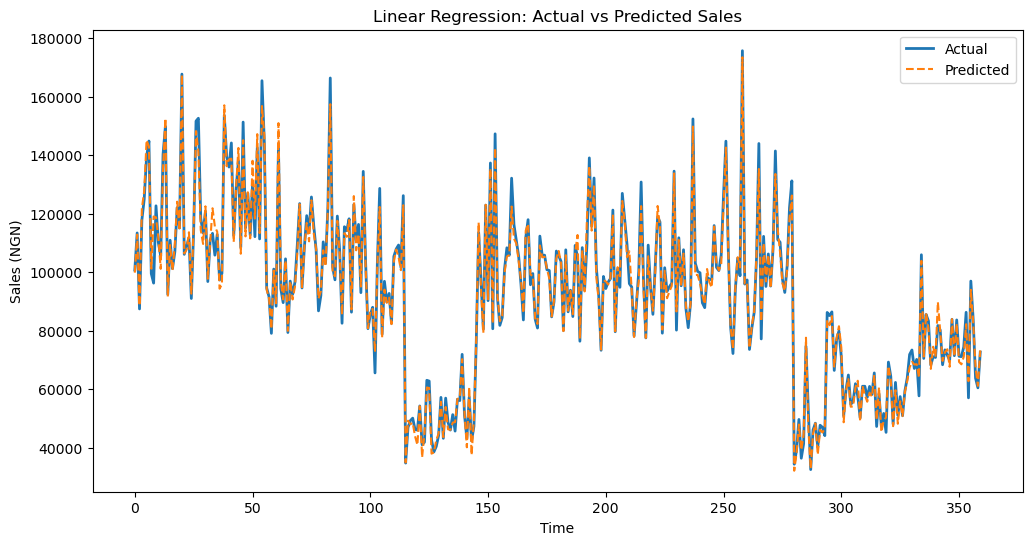

In [51]:
# Visualizing the Linear Regression Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (NGN)')
plt.legend()
plt.show()

In [52]:
# Evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 2249.13
RMSE: 3205.23
R² Score: 0.99


### Random Forest Regression

In [53]:
# Fitting the Random Forest Regression Model into the Dataset
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=0)

In [54]:
rf_y_pred = rf_regressor.predict(X_test)


In [55]:
rf_y_pred

array([ 98917.95      , 113702.09666667,  87313.12333333, 116820.42      ,
       122794.85333333, 138518.46666667, 149791.67      , 101203.16333333,
       119057.87      , 123229.78666667, 107212.82      , 104645.05666667,
       143479.50666667, 137782.13666667,  93467.63      , 111649.42666667,
       100234.75      , 108024.25333333, 118852.52333333, 114391.26      ,
       147110.17333333, 106023.93666667, 110096.14666667, 114506.3       ,
        91541.08      , 114898.5       , 151030.14333333, 151840.02666667,
       118837.55666667, 116687.45666667, 118160.74333333,  96305.25666667,
       113756.77666667, 114056.18      , 106446.98      , 114024.17      ,
        97000.83666667,  99127.49666667, 137795.18      , 137979.5       ,
       139265.47666667, 147282.69333333, 113535.45      , 128909.80333333,
       134529.85666667, 106595.75666667, 153116.36      , 117675.28333333,
       124051.24666667, 113761.62666667, 125123.01      , 109213.54333333,
       131189.06666667, 1

In [56]:
y_test

1466    100698.0
1467    113386.0
1468     87418.0
1469    117786.0
1470    124979.0
          ...   
1821     96933.0
1822     83812.0
1823     63783.0
1824     60455.0
1825     72670.0
Name: daily_sales_NGN, Length: 360, dtype: float64

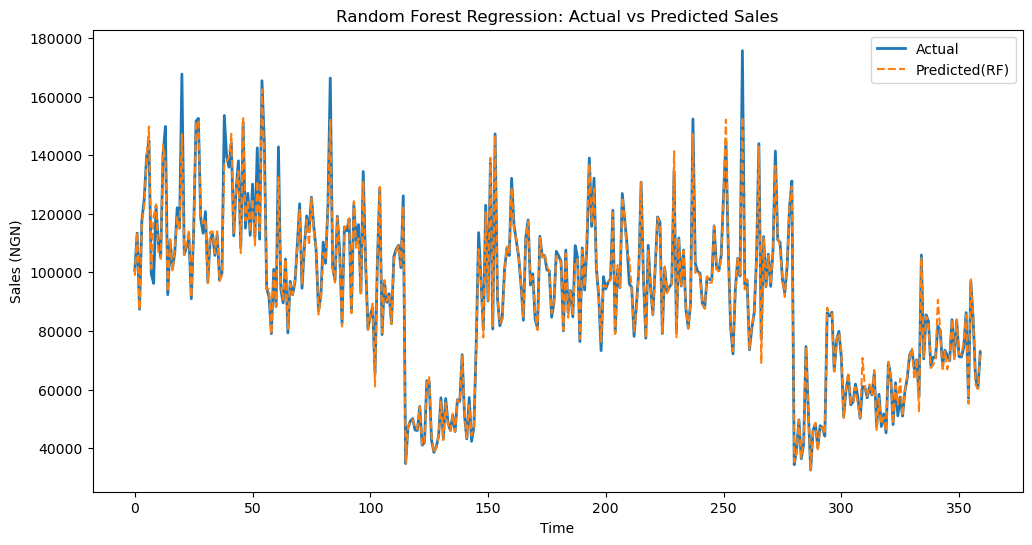

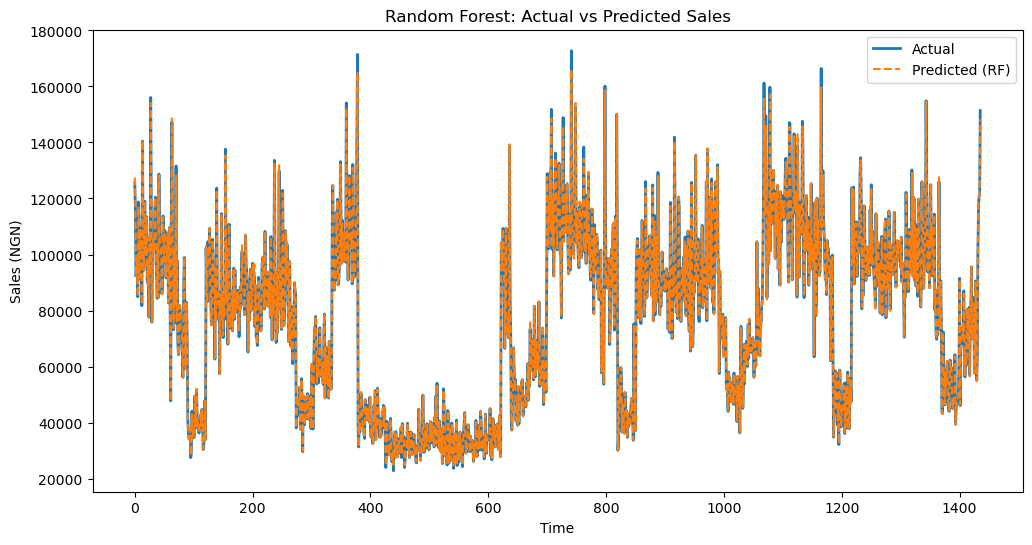

In [57]:
# Visualizing the Random Forest Predictions on Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(rf_y_pred, label='Predicted(RF)', linestyle='--')
plt.title('Random Forest Regression: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (NGN)')
plt.legend()
plt.show()



 # Visualizing the Random Forest Predictions on Train Set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train.values, label='Actual', linewidth=2)
plt.plot(rf_regressor.predict(X_train), label='Predicted (RF)', linestyle='--')
plt.title('Random Forest: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (NGN)')
plt.legend()
plt.show()

In [58]:
# Evaluting model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test, rf_y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_y_pred))
r2_rf = r2_score(y_test, rf_y_pred)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest MAE: 1564.27
Random Forest RMSE: 3172.98
Random Forest R²: 0.99


In [59]:
# Feature Importance from Random Forest Model
import pandas as pd

feature_importance = rf_regressor.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

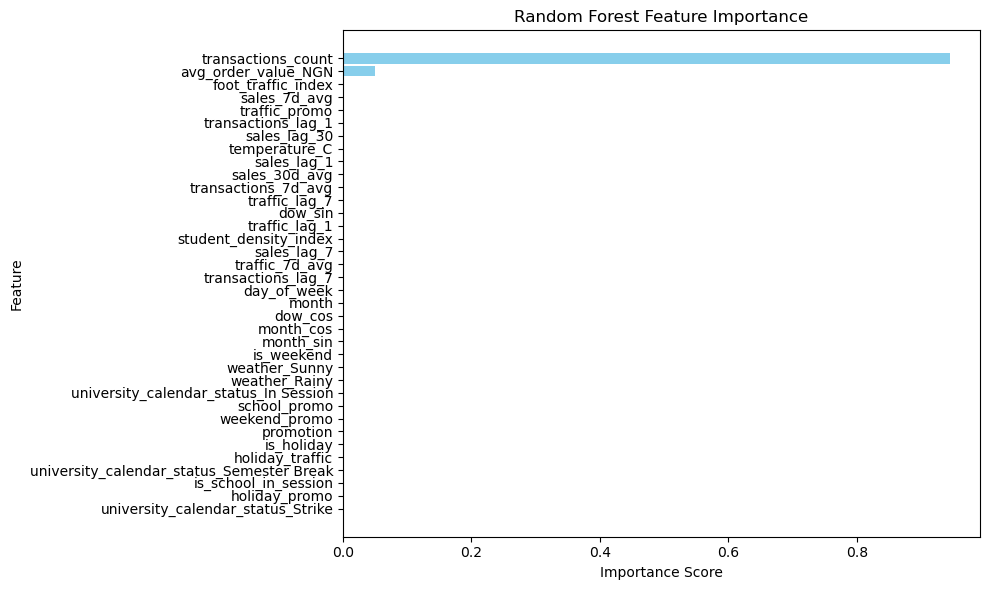

In [60]:
# Visualizing Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [61]:
# Model Refinement; Filter out the features with low importance and keep the ones with high importance(top 10)

top_features = importance_df['Feature'].head(10).tolist()
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]



In [62]:
# Try retraining with only the top 10 features

rf_regressor_reduced = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor_reduced.fit(X_train_reduced, y_train)

RandomForestRegressor(n_estimators=300, random_state=0)

In [63]:
rf_y_pred_reduced = rf_regressor_reduced.predict(X_test_reduced)


In [64]:
rf_y_pred_reduced

array([ 99052.16333333, 113852.19      ,  87020.90666667, 117738.13333333,
       123162.61666667, 137561.85666667, 148873.57333333, 100914.76      ,
       118247.96666667, 123020.49      , 106936.44      , 104306.29333333,
       142960.03333333, 139334.42333333,  93226.53333333, 111500.15666667,
       100268.50333333, 107553.38666667, 119963.        , 114213.53      ,
       146959.9       , 106018.01333333, 110177.88333333, 114549.65666667,
        91316.16333333, 114877.82      , 150561.63666667, 151795.86333333,
       119016.84      , 116358.53      , 118160.02      ,  96743.27666667,
       112914.38333333, 113383.92333333, 105788.91      , 113208.44      ,
        96662.84666667,  99160.26333333, 141685.38666667, 139110.49333333,
       138439.07666667, 146708.37      , 113312.59      , 129233.44333333,
       139141.        , 106826.86      , 153866.29333333, 117634.92666667,
       124228.22      , 113686.27666667, 128635.31666667, 110025.14333333,
       137481.44666667, 1

In [65]:
# Evaluting the Refined model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test, rf_y_pred_reduced)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_y_pred_reduced))
r2_rf = r2_score(y_test, rf_y_pred_reduced)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest MAE: 1389.08
Random Forest RMSE: 2928.56
Random Forest R²: 0.99


### XGBoost

In [66]:
# Fitting the XGBoost Regression Model into the Dataset using the redudced feature set
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=0)
xgb_regressor.fit(X_train_reduced, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [67]:
xgb_y_pred = xgb_regressor.predict(X_test_reduced)

In [68]:
xgb_y_pred

array([ 99902.28 , 112314.8  ,  87579.97 , 119352.04 , 123333.96 ,
       136725.5  , 151829.23 , 101069.09 , 115943.234, 122469.78 ,
       108926.95 , 104634.305, 146282.88 , 143528.88 ,  92937.484,
       109743.625, 100996.04 , 107726.3  , 123583.86 , 114484.33 ,
       139960.78 , 106347.04 , 109180.57 , 113415.1  ,  91627.3  ,
       115512.375, 148505.4  , 154572.02 , 118583.41 , 112808.42 ,
       122944.2  ,  96820.266, 112473.07 , 115576.37 , 104625.67 ,
       111918.02 ,  96920.83 ,  99605.8  , 145074.67 , 136799.84 ,
       135697.92 , 146138.08 , 113957.56 , 131127.16 , 135763.9  ,
       108928.445, 146958.44 , 113536.03 , 126375.38 , 112079.81 ,
       131307.33 , 112653.414, 139954.58 , 111830.01 , 162132.78 ,
       142880.6  ,  94482.83 ,  91589.36 ,  79155.71 , 100854.58 ,
        87909.87 , 140177.84 ,  95045.73 ,  89106.74 , 104550.38 ,
        79813.63 ,  96818.17 ,  92209.914,  96623.03 , 108251.55 ,
       121593.266,  95973.95 , 109058.52 , 120223.37 , 115380.

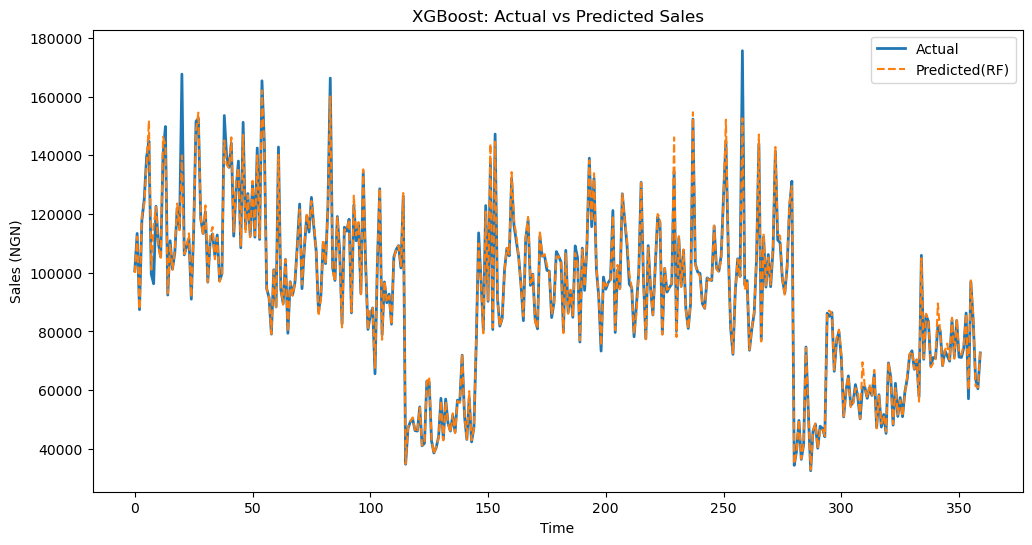

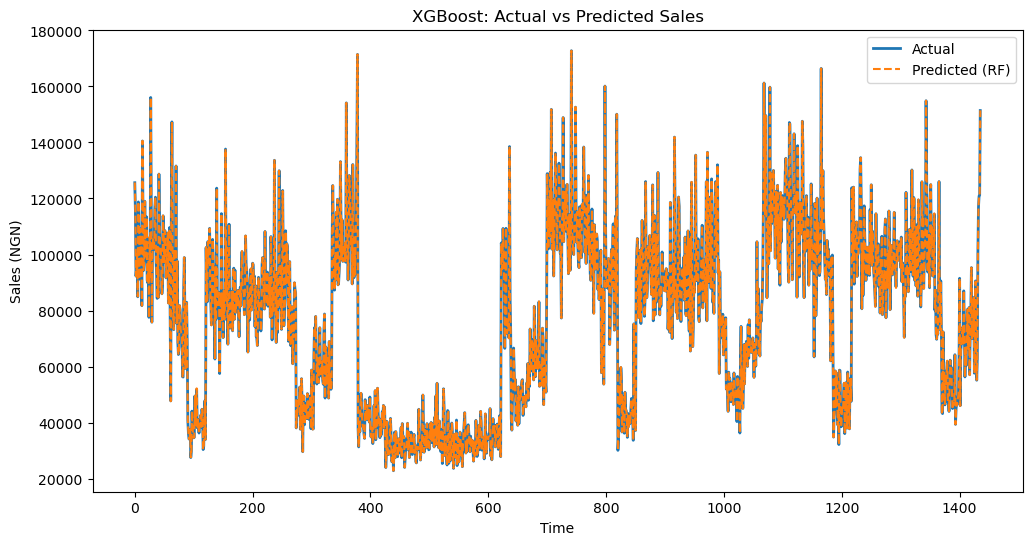

In [69]:
# Visualizing the XGBoost Predictions on Test Set
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(xgb_y_pred, label='Predicted(RF)', linestyle='--')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (NGN)')
plt.legend()
plt.show()



 # Visualizing the XGBoost Predictions on Train Set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train.values, label='Actual', linewidth=2)
plt.plot(xgb_regressor.predict(X_train_reduced), label='Predicted (RF)', linestyle='--')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (NGN)')
plt.legend()
plt.show()

In [70]:
# Evaluting XGBoost model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_xgb = mean_absolute_error(y_test, xgb_y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
r2_xgb = r2_score(y_test, xgb_y_pred)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")

XGBoost MAE: 1209.57
XGBoost RMSE: 2766.35
XGBoost R²: 0.99


In [71]:
# Fine Tiuning and Hyperparameter Optimization can be done using GridSearchCV or RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_reduced, y_train)

best_model = grid_search.best_estimator_

c:\Users\odebi\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [73]:
# Evaluate the best model
y_pred_best = best_model.predict(X_test_reduced)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Best XGBoost MAE: {mae_best:.2f}")
print(f"Best XGBoost RMSE: {rmse_best:.2f}")
print(f"Best XGBoost R²: {r2_best:.2f}")

Best XGBoost MAE: 1090.23
Best XGBoost RMSE: 2371.11
Best XGBoost R²: 0.99


## Finalize Model Pipeline


In [75]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib

# Build pipeline with only the model
pipeline = Pipeline(steps=[
    ('model', best_model)
])

# Train the pipeline on your reduced, preprocessed data
pipeline.fit(X_train_reduced, y_train)

# Save the pipeline
joblib.dump(pipeline, 'xgboost_final_pipeline.pkl')

['xgboost_final_pipeline.pkl']

In [76]:
## I still want to make some changeseg add all the pre preocessing steps to the model pipeline before deploying it.

## Launch the Model on Streamlit app

 Let's Launch the model..
  